In [1]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

#マスタデータのインポート
master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
plid = pd.read_csv(os.getcwd()+"/Resources/plid_master.csv",dtype=str)
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])

# XMLファイルを解析
tree = ET.parse('/Users/isakakou/Desktop/933704_NECGvKOBE_final_whistle_superscout.xml') 

# XMLを取得
root = tree.getroot()
df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
           'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
           'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
           'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

for action in root.iter('ActionRow'):
    s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                   action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                   action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                   action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                   action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                   action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                   action.get('advantage'),action.get('assoc_player')], index = df.columns)
    df = df.append(s, ignore_index=True)

df[['x_coord', 'y_coord']] = df[['x_coord', 'y_coord']].astype(np.uint8)

df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
df.action = df.action.map(master.set_index('ID').Definition)

df.team_id = df.team_id.map(tid.set_index('team_id').team_name)
df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
# df.to_csv('/Users/isakakou/Desktop/933693_NECGvKINT_final_whistle_superscout.csv', header=True, index=False)

# Ruck Speed

qualifier4  0-1 Seconds  1-2 Seconds  3-4 Seconds  4-5 Seconds  5-6 Seconds  \
action                                                                        
Ruck                  2            7           22            9            1   

qualifier4  6+ Seconds  N/A Ruck Speed  
action                                  
Ruck                 3               5  


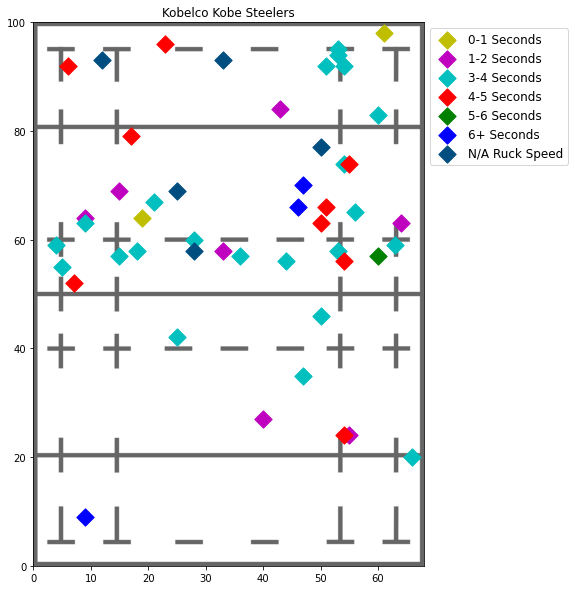

In [6]:
TEAMNAME = 'Kobelco Kobe Steelers'
dfaction = df.loc[(df['team_id'] == TEAMNAME)]

dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
rspeed = ['0-1 Seconds','1-2 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', "N/A Ruck Speed"]
cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
fig = plt.figure(figsize=(7, 10))
ax = fig.add_subplot(1, 1,1)
plt.xlim(0, 68)
plt.ylim(0,100)

a = pd.crosstab(dfaction['action'],dfaction['qualifier4'])
a = a.reindex(columns=rspeed).fillna(0).astype(int)
a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')
print(a)

#背景画像の設定
fig.patch.set_facecolor('white')
im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

for i in range(len(rspeed)):
    r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
    plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

#ラベルの表示
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
plt.title(TEAMNAME)
plt.gcf().subplots_adjust(wspace=4)

In [3]:
dfaction = df.loc[(df['team_id'] == TEAMNAME)]

players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
player_list = players['PLID']
player_list = player_list.reset_index(drop=True)
carry_meter = pd.DataFrame()

for i in range(len(player_list)):
    player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
    carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
    carry_list = carry['Metres'].astype(int)
    s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
    carry_meter = carry_meter.append(s, ignore_index=True)

print(carry_meter)
carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')

    Metres                   Name
0      0.0  Green Rockets Tokatsu
1     80.0         Taisetsu Kanai
2     83.0        Maritino Nemani
3    143.0          Lomano Lemeki
4     29.0      Kavaia Tagivetaua
5      0.0        Koichi Matsuura
6     19.0            Luke Porter
7      0.0            Nick Phipps
8     97.0            Kanta Omata
9    101.0           Tom Marshall
10    11.0         Yoshiya Hosoda
11    19.0          Gakuto Ishida
12    21.0              Miyu Arai
13    92.0          Aseri Masivou
14    20.0             Ryoi Kamei
15     9.0           Takahiro Doi
16    99.0           Tim Bennetts
17    45.0          Tatsuru Owada
18     3.0         Sunao Takizawa
19     3.0           Satoshi Ueda
20     5.0          Tatsuya Fujii
21    13.0  Whetukamokamo Douglas
22    14.0              Ash Dixon
23    64.0            Teruya Goto
